In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import scipy
from sklearn import linear_model

In [2]:
def load_pickles(path):
    pickle_file = pd.read_pickle(path)
    return pickle_file

def highest_reviews(restaurant_reviews_df):
    
    #Restaurant with highest number of reviews (3)
    temp_df = pd.DataFrame(data = restaurant_reviews_df.groupby('business_id').size()).reset_index()
    temp_df.columns = ['business_id', 'number_of_reviews']
    ans = temp_df.nlargest(2,'number_of_reviews')    
    return ans

def groupby_date(restaurant_of_interest):
    year = []
    month = []
    for index, row in restaurant_of_interest.iterrows():
        split_date = row['date'].split('-')
        if int(split_date[0])>2012:
            year.append(split_date[0])
            month.append(split_date[1])

    year = pd.Series(year)
    month = pd.Series(month)
    hotel = pd.DataFrame()
    hotel['year'] = year.values
    hotel['month'] = month.values

    ans = hotel.groupby(['year', 'month']).size().reset_index()
    ans.columns = ['year', 'month','total_reviews']
    
    return ans

def create_train_test(restaurant_df):
    train_df = restaurant_df[restaurant_df['year']<'2017']
    test_df = restaurant_df[restaurant_df['year']=='2017']
    return train_df,test_df

def concatenate(df):
    year_month = []
    total_reviews=[]
    for index, row in df.iterrows():
        year_month.append(row['year']+'_'+row['month'])
        total_reviews.append(row['total_reviews'])
    year_month = pd.Series(year_month)
    total_reviews=pd.Series(total_reviews)
    df_new = pd.DataFrame()
    df_new['year-month']= year_month.values
    df_new['reviews']=total_reviews.values
    
    return df_new

def seasonal(train_df,test_df,pred_start,pred_end):
    
    season = 12
    df = pd.DataFrame()
    previous_reviews = train_df['total_reviews']
    predicted_reviews = []
    actual_reviews = []
    train_2016 = train_df[train_df['year']=='2016']
    test_2017 = test_df[test_df['year']=='2017']
    count2016 = 0
    count2017 = 0
    
    for index,row in train_2016.iterrows():
        count2016 += row['total_reviews']
    
    for index,row in test_2017.iterrows():
        count2017 += row['total_reviews']
        
    for index,row in test_df.iterrows():
        actual_reviews.append(float(row['total_reviews']/count2017))
    
    for index in range(pred_start,pred_end+1):
        predicted_reviews.append(float(previous_reviews[index-season]/count2016))
        
    df['predicted_reviews'] = predicted_reviews
    df['actual_reviews'] = actual_reviews
    return df

def emwa(train_df,test_df,alpha):
    
        train_2016 = train_df[train_df['year']=='2016']
        test_2017 = test_df[test_df['year']=='2017']
        count2016 = 0
        count2017 = 0
    
        for index,row in train_2016.iterrows():
            count2016 += row['total_reviews']
    
        for index,row in test_2017.iterrows():
            count2017 += row['total_reviews']
            
        indices = np.arange(len(test_df))
        predicted_reviews = []
        predicted_reviews.append(int(train_df['total_reviews'].tail(1)))
        test_reviews = pd.DataFrame(test_df['total_reviews']).reset_index()
        for index in range(1,len(test_df)):
            predicted_reviews.append(alpha*int(test_reviews.iloc[index-1]['total_reviews']) + (1-alpha)*(int(predicted_reviews[index-1])))
            
        df = pd.DataFrame()
        
        pred_new = [float(x/count2016) for x in predicted_reviews]
        df['predicted_reviews'] = pred_new
        
        actual_new = []
        
        for index,row in test_df.iterrows():
            actual_new.append(float(row['total_reviews']/count2017))
        
        df['actual_reviews'] = actual_new
        return df
    
def average_error(actual_data, predicted_data,start,end):
    print('hi')
    average = 0
    for index in range(start,end):
        average = average + (abs(actual_data[index] - predicted_data[index]) / actual_data[index]) * 100
    average = average / len(actual_data)
    return average

def autoregression(actual_data, training_data_start, training_data_end, test_data_start, test_data_end, p,count2016):
    X_train, Y_train, X_test = [], [], []
    for index in range(training_data_start + p, training_data_end + 1):
        X_train.append(actual_data[index - p : index])
        Y_train.append(actual_data[index])

    predicted_data = []
    for index in range(test_data_start, test_data_end + 1):
        regr = linear_model.LinearRegression()
        regr.fit(X_train, Y_train)
        predicted_data.append(regr.predict([actual_data[index - p : index]])[0])
        X_train.append(actual_data[index - p : index])
        Y_train.append(actual_data[index])
    
    df = pd.DataFrame()
    predicted_data = [float(x/count2016) for x in predicted_data]
    df['predicted_reviews'] = predicted_data
    return df


In [3]:
#loading the pickle files
print("Loading the pickle files..")
reviews = load_pickles("C:/Users/tjnai/Downloads/reviews.pickle")
businesses = load_pickles("C:/Users/tjnai/Downloads/business.pickle")
business_categories = load_pickles("C:/Users/tjnai/Downloads/business_categories.pickle")

#Converting into dataframes
print("Converting them to dataframes..")
bcategories_df = pd.DataFrame(data=business_categories)
reviews_df = pd.DataFrame(data=reviews)



Loading the pickle files..
Converting them to dataframes..


In [4]:
#Selecting only tan businesses from all businesses
print("Finding tanning businesses..")
shopping_df = pd.DataFrame(bcategories_df[bcategories_df['category_name'].isin(['Spray Tanning','Tanning'])])

#Finding reviews of tan businesses
shopping_reviews = pd.merge(shopping_df,reviews_df, on='business_id')

#Select columns
shopping_reviews_df = shopping_reviews[['business_id','date','review_id','stars','user_id']]

Finding tanning businesses..


In [5]:
print('Finding highest tanning reviews')
businesses_df = pd.DataFrame(data=businesses)
highest_reviews_df = highest_reviews(shopping_reviews_df)

Finding highest tanning reviews


In [6]:
highest_reviews_df

,business_id,number_of_reviews
598,kW0U0xCT6w-5lkLt_k0ysA,536
346,Se9dkAqNfBoOoAbKT0LEsg,440


In [7]:
def time_series():
    
    shop_id = 'kW0U0xCT6w-5lkLt_k0ysA'
    
    #Creating training and testing data
    shop_of_interest = shopping_reviews_df[shopping_reviews_df['business_id']==shop_id]
    ans = groupby_date(shop_of_interest)
    print(ans)
    train_df,test_df = create_train_test(ans)
    train_df_concat = concatenate(train_df)
    
     #Seasonal time series
    df = seasonal(train_df,test_df,35,46).reset_index()
    df.columns = ['months','predicted_reviews','actual_Reviews']
    df_temp = df.iloc[3:8]
    plt = df_temp.plot(x='months',y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('Seasonal for Spray Tanning Businesses (Mar-July)')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual[3:8],pred[3:8],3,8)
   
    
    print("Seasonal time series error : ",avg_error)


     #EMWA time series
    df = emwa(train_df,test_df,0.8)
    df.columns = ['predicted_reviews','actual_Reviews']
    df_temp = df.iloc[3:8]
   
    plt = df_temp.plot(x=df_temp.index,y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('EWMA (alpha=0.8) for Spray Tanning Businesses (Mar-Aug)')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual[3:8],pred[3:8],3,8)
    print("EWMA time series error : ",avg_error)
    

    train_2016 = train_df[train_df['year']=='2016']
    test_2017 = test_df[test_df['year']=='2017']
    count2016 = 0
    count2017 = 0

    for index,row in train_2016.iterrows():
        count2016 += row['total_reviews']

    for index,row in test_2017.iterrows():
        count2017 += row['total_reviews']
    
    
    #print("AutoRegression series")
    data = []
    for index,row in ans.iterrows():
        data.append(row['total_reviews'])
  
    df = autoregression(data,0,34,35,46,12,count2016)
    temp = []
    for index,row in test_df.iterrows():
        temp.append(float(row['total_reviews']/count2017))
        
    df['actual_Reviews']=temp
    df.columns = ['predicted_reviews','actual_Reviews']
    df_temp = df.iloc[3:8]
 
    
    plt = df_temp.plot(x=df_temp.index,y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('AutoRegression (p=12) for Tanning Businesses (Mar-Aug)')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual[3:8],pred[3:8],3,8)
    print("Autoregression time series error : ",avg_error)
    
   
   


    year month  total_reviews
0   2014    02              8
1   2014    03             12
2   2014    04             10
3   2014    05              8
4   2014    06              4
5   2014    07              6
6   2014    08             10
7   2014    09              4
8   2014    10             16
9   2014    11              2
10  2014    12             10
11  2015    01             16
12  2015    02              8
13  2015    03             22
14  2015    04              6
15  2015    05             16
16  2015    06              6
17  2015    07              8
18  2015    08              4
19  2015    09              2
20  2015    10             18
21  2015    11              4
22  2015    12             26
23  2016    01             18
24  2016    02              8
25  2016    03             18
26  2016    04             16
27  2016    05             20
28  2016    06             16
29  2016    07             12
30  2016    08             12
31  2016    09             34
32  2016  

C:\Users\tjnai\Anaconda2\envs\py36\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


hi
Seasonal time series error :  32.09621993127148
hi
EWMA time series error :  49.03780068728523
hi
Autoregression time series error :  53.438136211135586


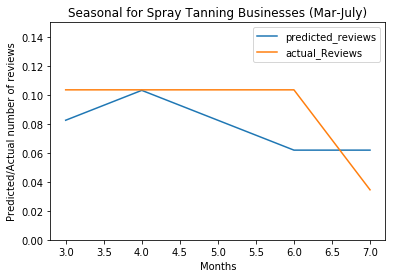

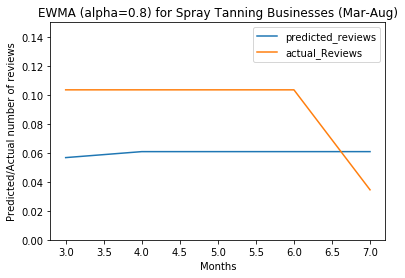

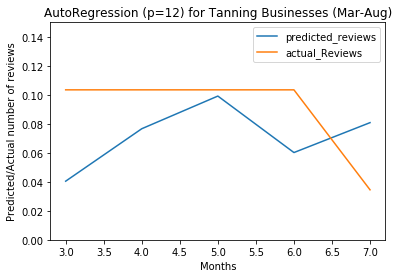

In [8]:
time_series()

In [9]:
#Selecting only tan businesses from all businesses
print("Finding nightlife businesses..")
shopping_df = pd.DataFrame(bcategories_df[bcategories_df['category_name'].isin(['Nightlife','Bars'])])

#Finding reviews of shops
shopping_reviews = pd.merge(shopping_df,reviews_df, on='business_id')

#Select columns
shopping_reviews_df = shopping_reviews[['business_id','date','review_id','stars','user_id']]

Finding nightlife businesses..


In [10]:
print('Finding highest nightlife reviews')
businesses_df = pd.DataFrame(data=businesses)
highest_reviews_df = highest_reviews(shopping_reviews_df)

Finding highest nightlife reviews


In [11]:
highest_reviews_df

,business_id,number_of_reviews
4190,KskYqH1Bi7Z_61pH6Om8pg,7930
1703,7sPNbCx7vGAaH7SbNPZ6oA,6128


In [12]:
def time_series1():
    
    shop_id = 'KskYqH1Bi7Z_61pH6Om8pg'
    
    #Creating training and testing data
    shop_of_interest = shopping_reviews_df[shopping_reviews_df['business_id']==shop_id]
    ans = groupby_date(shop_of_interest)
    print(ans)
    train_df,test_df = create_train_test(ans)
    train_df_concat = concatenate(train_df)
    
     #Seasonal time series
    df = seasonal(train_df,test_df,48,59).reset_index()
    df.columns = ['months','predicted_reviews','actual_Reviews']
    #df_temp = df.iloc[4:7]
    plt = df.plot(x='months',y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('Seasonal for Tanning Businesses (Mar-Aug)')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual,pred,0,12)
   
    
    print("Seasonal time series error : ",avg_error)


     #EMWA time series
    df = emwa(train_df,test_df,0.8)
    df.columns = ['predicted_reviews','actual_Reviews']
    #df_temp = df.iloc[4:7]
   
    plt = df.plot(x=df.index,y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('EWMA (alpha=0.8) for Nightlife Industry (2017)')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual,pred,0,12)
    print("EWMA time series error : ",avg_error)
    

    train_2016 = train_df[train_df['year']=='2016']
    test_2017 = test_df[test_df['year']=='2017']
    count2016 = 0
    count2017 = 0

    for index,row in train_2016.iterrows():
        count2016 += row['total_reviews']

    for index,row in test_2017.iterrows():
        count2017 += row['total_reviews']
    
    
    #print("AutoRegression series")
    data = []
    for index,row in ans.iterrows():
        data.append(row['total_reviews'])
  
    df = autoregression(data,0,47,48,59,12,count2016)
    temp = []
    for index,row in test_df.iterrows():
        temp.append(float(row['total_reviews']/count2017))
        
    df['actual_Reviews']=temp
    df.columns = ['predicted_reviews','actual_Reviews']
    #df_temp = df.iloc[4:7]
 
    
    plt = df.plot(x=df.index,y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('AutoRegression (p=12) for Tanning Businesses (Mar-Aug)')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual,pred,0,12)
    print("Autoregression time series error : ",avg_error)
    
   
   


    year month  total_reviews
0   2013    01             78
1   2013    02             64
2   2013    03             78
3   2013    04             82
4   2013    05             70
5   2013    06             72
6   2013    07             64
7   2013    08             76
8   2013    09             74
9   2013    10             44
10  2013    11             72
11  2013    12            106
12  2014    01             98
13  2014    02             86
14  2014    03             72
15  2014    04             70
16  2014    05             88
17  2014    06            104
18  2014    07            102
19  2014    08             92
20  2014    09             78
21  2014    10             62
22  2014    11             66
23  2014    12             98
24  2015    01            118
25  2015    02             98
26  2015    03            110
27  2015    04             70
28  2015    05            100
29  2015    06            186
30  2015    07            172
31  2015    08            162
32  2015  

C:\Users\tjnai\Anaconda2\envs\py36\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


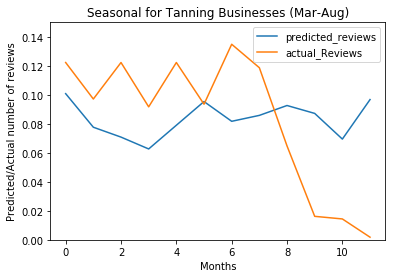

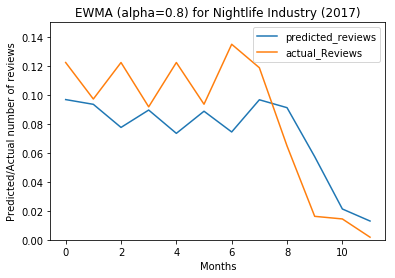

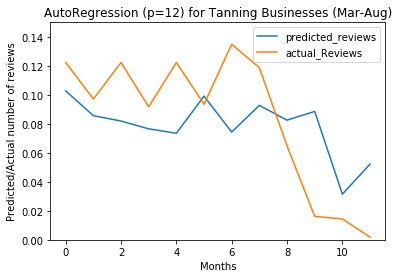

In [13]:
time_series1()